<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/main/Class_DICOM_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

##### **Module 6: Advanced Topics**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Biology, Health and the Environment](https://sciences.utsa.edu/bhe/), [UTSA](https://www.utsa.edu/)

### Module 6 Material

* Part 3.1: Using Convolutional Neural Networks
* **Part 3.2: Using Pre-Trained Neural Networks with Keras**
* Part 3.3: Facial Recognition and Analysis
* Part 3.4: Introduction to GAN's for Image and Data Generation

#### **Change your Runtime Now!**

For this lesson you must have a GPU hardware accelerator (e.g. `A100` with `High-RAM` if available).

## Google CoLab Instructions

You MUST run the following code cell to get credit for this class lesson. By running this code cell, you will map your GDrive to /content/drive and print out your Google GMAIL address. Your Instructor will use your GMAIL address to verify the author of this class lesson.

In [1]:
# You must run this cell first
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from google.colab import auth
    auth.authenticate_user()
    Colab = True
    print("Note: Using Google CoLab")
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
    print(gcloud_tokeninfo['email'])
except:
    print("**WARNING**: Your GMAIL address was **not** printed in the output below.")
    print("**WARNING**: You will NOT receive credit for this lesson.")
    Colab = False

Mounted at /content/drive
Note: Using Google CoLab
david.senseman@gmail.com


You should see the following output except your GMAIL address should appear on the last line.

![__](https://biologicslab.co/BIO1173/images/class_01/class_01_6_image01A.png)

If your GMAIL address does not appear your lesson will **not** be graded.

## Accelerated Run-time Check

You MUST run the following code cell to get credit for this class lesson. The code in this cell checks what hardware acceleration you are using. To run this lesson, you must be running a Graphics Processing Unit (GPU).

In [2]:
# You must run this cell second

import tensorflow as tf

# ------------------------------------------------------------------------
# 0️⃣  Create check_device() function
# ------------------------------------------------------------------------

def check_device():
    # Check for available devices
    devices = tf.config.list_physical_devices()

    # Initialize device flags
    cpu = False
    gpu = False
    tpu = False

    # Check device types
    for device in devices:
        if device.device_type == 'CPU':
            cpu = True
        elif device.device_type == 'GPU':
            gpu = True
        elif device.device_type == 'TPU':
            tpu = True

    # Output device status
    if tpu:
        print("Running on TPU")
        print("WARNING: You must run this assigment using a GPU to earn credit")
        print("Change your RUNTIME now!")
    elif gpu:
        print("Running on GPU")
        gpu_info = !nvidia-smi
        gpu_info = '\n'.join(gpu_info)
        print(gpu_info)
        print("You are using a GPU hardware accelerator--You're good to go!")
    elif cpu:
        print("Running on CPU")
        print("WARNING: You must run this assigment using a GPU to earn credit")
        print("Change your RUNTIME now!")
    else:
        print("No compatible device found")
        print("WARNING: You must run this assigment using either a GPU or a TPU to earn credit")
        print("Change your RUNTIME now!")

# ------------------------------------------------------------------------
# 1️⃣  Call function
# ------------------------------------------------------------------------

check_device()

Running on GPU
Thu Sep 25 00:27:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             54W /  400W |       5MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+--------------------------------

If you current `Runtime` is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_05/class_05_4_image11A.png)

However, if you received this warning message

![__](https://biologicslab.co/BIO1173/images/class_05/class_05_4_image14A.png)

You **MUST** go back and change your `Runtime` **NOW** before you continue.

### Create Custom Function

The cell below creates a custom function called `hms_string()`. This function is needed to record the time required to train your neural network model.

If you fail to run this cell now, you will receive one (or more) error message(s) later in this lesson.

In [2]:
# Create custom function

# ------------------------------------------------------------------------
# 0️⃣  Create hms_string()
# ------------------------------------------------------------------------

# Simple function to print out elasped time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

### Install Packages

Run the code in the next cell to install necessary packages for this lesson.

In [3]:
# Install Packages

!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 87.6 MB/s eta 0:00:00


If the code is correct you should see the following output



### Download and Extract Data

Run the code in the next cell to download and extract the DICOM image dataset for this lesson.

In [4]:
# ────────────────────────────────────────────────────────────────────────────────
#  Lazy DICOM loader
# ────────────────────────────────────────────────────────────────────────────────
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import pydicom
import numpy as np
from pathlib import Path
import gc
from PIL import Image
import torchvision.transforms as T

import numpy as np
import pydicom
from PIL import Image
import torch
import torchvision.transforms as T

class DicomImageDataset(torch.utils.data.Dataset):
    def __init__(self,
                 file_paths,
                 labels,
                 transform=None,
                 gray_scale=False):
        """
        Args:
            file_paths (Iterable[str]): Paths to DICOM files.
            labels (Iterable[int]): Class indices.
            transform (callable, optional): torchvision transform pipeline.
            gray_scale (bool, optional): If True, convert the image to a
                                         single‑channel (grayscale) tensor.
        """
        self.file_paths = list(file_paths)
        self.labels = np.array(labels, dtype=np.int64)
        self.gray_scale = gray_scale

        # ---- 1. Default transform (PIL → Tensor) ------------------------------
        # The compose must be *outside* of any other list or property.
        self.transform = transform or T.Compose([
            T.Resize(256),          # (optional) change to your size
            T.CenterCrop(224),
            T.ToTensor(),           # converts PIL image to FloatTensor [C, H, W]
            T.Normalize(mean=[0.5], std=[0.5])   # single‑channel stats
        ])

    # ---- 2. Property: number of classes ------------------------------------
    @property
    def num_classes(self):
        """Return the number of distinct classes in the dataset."""
        return len(set(self.labels.tolist()))

    # ---- 3. Dataset interface -----------------------------------------------
    def __len__(self) -> int:
        return len(self.file_paths)

    def __getitem__(self, idx: int):
        # Load the DICOM *only when requested*
        dicom_path = self.file_paths[idx]
        ds = pydicom.dcmread(dicom_path)

        # Grab the pixel data and cast to float32 for later scaling
        img = ds.pixel_array.astype(np.float32)

        # If the image is 16‑bit (or any bit depth) we rescale to 0‑255.
        # (pixel_array is usually uint16 for CT/MRI scans)
        if img.dtype != np.uint8:
            img = img - np.min(img)          # shift to zero
            img = img / np.max(img)           # scale to [0, 1]
            img = (img * 255).astype(np.uint8)

        # Handle 3‑channel data: if the pixel array already has 3 channels
        # we keep it as‑is; otherwise we treat it as single‑channel.
        if img.ndim == 3 and img.shape[2] > 1:
            # If you want RGB, keep the 3 channels
            mode = "RGB"
        else:
            # Convert to 2‑D (single channel) if necessary
            mode = "L"  # PIL mode for grayscale

        # Convert to PIL image
        pil_img = Image.fromarray(img, mode=mode)

        # If gray_scale is True we convert the image to grayscale *again*
        # (PIL will convert to mode 'L' anyway, but this keeps the logic
        # explicit for clarity).
        if self.gray_scale and pil_img.mode != "L":
            pil_img = pil_img.convert("L")

        # Apply the transform (if any). The Compose expects a PIL image.
        if self.transform:
            pil_img = self.transform(pil_img)

        # Return the tensor + label
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return pil_img, label



In [5]:
# Download and Extract Data

"""
from pathlib import Path
import requests
import zipfile
import sys
import shutil
import os
import warnings
import numpy as np
import pandas as pd
import pydicom
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torchvision import transforms, models
"""
from pathlib import Path
import requests
import zipfile
import sys
import shutil
import os
import warnings


# ------------------------------------------------------------------
# Configuration – change only if you want a different URL / filename
# ------------------------------------------------------------------
URL = "https://biologicslab.co/BIO1173/data/"
ZIP_FILENAME = "pna_data.zip"

# ------------------------------------------------------------------
# Download the zip file (streamed, so it works with large files)
# ------------------------------------------------------------------
def download_zip(url: str, dest: Path, chunk_size: int = 8192) -> None:
    """Download a file from `url` and write it to `dest`."""
    print(f"Downloading {ZIP_FILENAME} to {dest}...", end='')
    with requests.get(url, stream=True, timeout=30) as r:
        r.raise_for_status()           # will raise for 4xx/5xx
        with dest.open("wb") as f_out:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:               # filter out keep‑alive new chunks
                    f_out.write(chunk)
    print("done")

# ------------------------------------------------------------------
# Un‑zip the downloaded archive into a *named* directory
# ------------------------------------------------------------------
def unzip_file(zip_path: Path, extract_to: Path) -> None:
    """Extract all members of `zip_path` into `extract_to`."""
    print(f"Unzipping {ZIP_FILENAME} to {extract_to}...", end='')
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_to)
    print("done")

# ------------------------------------------------------------------
# Optional – delete the zip after extraction
# ------------------------------------------------------------------
def clean_up_zip(zip_path: Path) -> None:
    """Delete the zip file – only if you no longer need it."""
    zip_path.unlink()
    print(f"Removed temporary archive: {zip_path}... done")

# ------------------------------------------------------------------
# Main routine
# ------------------------------------------------------------------
def main() -> None:
    cwd          = Path.cwd()            # current working directory
    zip_path     = cwd / ZIP_FILENAME
    extract_dir  = cwd / zip_path.stem   # e.g. /pna_data

    # Ensure the extraction directory exists
    extract_dir.mkdir(parents=True, exist_ok=True)

    # Download
    download_zip(URL+ZIP_FILENAME, zip_path)

    # Un‑zip
    unzip_file(zip_path, extract_dir)

    # Clean‑up the downloaded archive
    clean_up_zip(zip_path)

    print(f"Files have been extracted to {extract_dir}")

# ------------------------------------------------------------------
if __name__ == "__main__":
    main()

Unzipping pna_data.zip to /content/pna_data...done
Removed temporary archive: /content/pna_data.zip... done
Files have been extracted to /content/pna_data


If the code is correct your should see the following output



### Process DICOM datafiles



In [20]:
# Process DICOM Files

import numpy as np
import pandas as pd
import pydicom
import warnings
from matplotlib import pyplot as plt
#import seaborn as sns

# Global settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
#sns.set_palette("husl")

# -------------------------------------------------------------
#  Helper: read a single DICOM file
# -------------------------------------------------------------
def read_dicom_file(file_path: str):
    """Read a DICOM file and extract image data + basic metadata."""
    ds = pydicom.dcmread(file_path)

    # Basic metadata
    metadata = {
        'filename': os.path.basename(file_path),
        'patient_name': getattr(ds, 'PatientName', 'Unknown'),
        'patient_id': getattr(ds, 'PatientID', 'Unknown'),
        'study_date': getattr(ds, 'StudyDate', 'Unknown'),
        'study_time': getattr(ds, 'StudyTime', 'Unknown'),
        'modality': getattr(ds, 'Modality', 'Unknown'),
        'manufacturer': getattr(ds, 'Manufacturer', 'Unknown'),
        'institution_name': getattr(ds, 'InstitutionName', 'Unknown'),
        'series_description': getattr(ds, 'SeriesDescription', 'Unknown'),
        'bits_allocated': getattr(ds, 'BitsAllocated', 'Unknown'),
        'rows': getattr(ds, 'Rows', 'Unknown'),
        'columns': getattr(ds, 'Columns', 'Unknown'),
        'pixel_spacing': getattr(ds, 'PixelSpacing', 'Unknown')
    }

    # Image data
    if hasattr(ds, 'pixel_array'):
        image_array = ds.pixel_array

        # Normalise to 0‑255 if needed
        if image_array.dtype != np.uint8:
            image_array = ((image_array - image_array.min()) /
                           (image_array.max() - image_array.min()) * 255).astype(np.uint8)

        metadata['image_available'] = True
        metadata['image_shape'] = image_array.shape
    else:
        metadata['image_available'] = False
        metadata['image_shape'] = 'No image data'

    return ds, metadata

# -------------------------------------------------------------
#  Helper: fast drop‑check
# -------------------------------------------------------------
def is_file_dropped(file_path: str) -> bool:
    """
    Quick guard that tells us whether a DICOM file is already
    missing / unreadable.
    """
    if not os.path.isfile(file_path):
        return True

    if os.path.getsize(file_path) == 0:
        return True

    try:
        pydicom.dcmread(file_path, stop_before_pixels=True)
    except Exception:
        return True

    return False

# -------------------------------------------------------------
#  Load & preprocess – merge CSVs, keep only valid DICOM rows
# -------------------------------------------------------------
def load_and_preprocess_data(
    data_dir: str = '.',
    log_dropped: bool = True
):
    # Load the two CSVs, merge on patient ID, and keep only rows
    # that have an intact DICOM image.
    info_df   = pd.read_csv(os.path.join(data_dir, 'pna_detailed_class_info.csv'))
    labels_df = pd.read_csv(os.path.join(data_dir, 'pna_train_labels.csv'))

    # Define patient ID variable
    info_id_col   = 'patientId'
    labels_id_col = 'patientId'

    merged_df = pd.merge(info_df, labels_df, left_on=info_id_col,
                         right_on=labels_id_col, how='inner')

    dicom_dir = os.path.join(data_dir, 'pna_train_images')
    valid_rows = []
    dropped_ids = []

    for idx, row in merged_df.iterrows():
        patient_id = row[info_id_col]
        dicom_file = os.path.join(dicom_dir, f"{patient_id}.dcm")

        if is_file_dropped(dicom_file):
            dropped_ids.append(patient_id)
        else:
            valid_rows.append(idx)

    filtered_df = merged_df.loc[valid_rows].copy()
    print(f"Filtered DataFrame shape (with valid DICOM files): {filtered_df.shape}")

    return filtered_df, dropped_ids


# ────────────────────────────────────────────────────────────────────────────────
#  Update load_and_preprocess_data to return only file‑paths + labels
# ────────────────────────────────────────────────────────────────────────────────
def load_file_paths_and_labels(filtered_df, max_samples=None):
    """
    Return two lists: `file_paths` and `labels`.  The function keeps the
    *original* logic that filtered out NaNs / duplicated rows – we simply
    strip it down to the very few objects that the new lazy loader needs.
    """
    file_paths = filtered_df["file_path"].tolist()
    labels = filtered_df["label"].tolist()

    if max_samples is not None:
        file_paths = file_paths[:max_samples]
        labels = labels[:max_samples]

    return file_paths, labels

# -------------------------------------------------------------
#  Main block – run the whole pipeline
# -------------------------------------------------------------
if __name__ == "__main__":
    # Path to the data root
    data_root = os.path.join('.', 'pna_data')




In [21]:
print(filtered_df)

NameError: name 'filtered_df' is not defined

### Select Number of DICOM Images to Process

The variable `MAX_SAMPLES` specifies how many of the 9337 images that will be used in this lesson.

In [11]:
# Define number of images to use
MAX_SAMPLES=9337

# Generate filtered_df
filtered_df, _ = load_and_preprocess_data(data_dir=data_root)

# Build X, y
X, y = create_dataset(filtered_df, data_dir=data_root, target_column='Target', max_samples=MAX_SAMPLES)

Filtered DataFrame shape (with valid DICOM files): (9337, 7)


NameError: name 'create_dataset' is not defined

If the code is correct you should see something _similar_ to the following output

In [ ]:
# Check Data

num_files = X.shape[0]      # <-- first element of the tuple

# Print image shapes
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Sample data shape:", X[0].shape if len(X) > 0 else "No data")


# Ensure the data type is correct
print(f"Processing {num_files} DICOM files...", end='')
X = X.astype(np.float32)
print("done")

Shape of X: (5000, 1024, 1024, 3)
Shape of y: (5000,)
Sample data shape: (1024, 1024, 3)
Processing 5000 DICOM files...done


### Create Plotting Functions

In [7]:
### **Create Plotting Functions**
import seaborn as sns

# Global settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


# Create Plotting Functions

# -------------------------------------------------------------
#  Show a single DICOM image (for sanity checks)
# -------------------------------------------------------------
def display_dicom_image(file_path: str, figsize: tuple = (10, 10)):
    """Show a single DICOM image with proper orientation."""
    ds = pydicom.dcmread(file_path)
    if hasattr(ds, 'pixel_array'):
        img = ds.pixel_array
        if getattr(ds, 'PhotometricInterpretation', None) == 'MONOCHROME1':
            img = np.max(img) - img

        plt.figure(figsize=figsize)
        plt.imshow(img, cmap='gray')
        plt.title(ds.SOPClassUID)
        plt.axis('off')
        plt.show()
    else:
        print("This DICOM has no pixel data.")

# -------------------------------------------------------------
#  Visualise class / target distributions
# -------------------------------------------------------------
def visualize_data_distribution(filtered_df: pd.DataFrame):
    if filtered_df is None:
        return

    plt.figure(figsize=(12, 6))

    # Class distribution
    plt.subplot(1, 2, 1)
    if 'class' in filtered_df.columns:
        class_counts = filtered_df['class'].value_counts()
        class_counts.plot(kind='bar')
        plt.title('Class Distribution')
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'No class column found', ha='center')
        plt.title('Class Distribution')

    # Target distribution
    plt.subplot(1, 2, 2)
    if 'Target' in filtered_df.columns:
        target_counts = filtered_df['Target'].value_counts()
        target_counts.plot(kind='bar')
        plt.title('Target Distribution')
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'No Target column found', ha='center')
        plt.title('Target Distribution')

    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------
#  Plot train and val history
# -------------------------------------------------------------
def plot_train_val(history: dict,
                 num_epochs: int,
                 batch_size: int,
                 title: str | None = None) -> None:
    """
    Plot a two‑panel figure:
        • Left panel – train & val accuracy.
        • Right panel – train & val loss.

    Parameters
    ----------
    history : dict
        Must contain the keys 'train_acc', 'val_acc',
        'train_loss', 'val_loss'.
    num_epochs : int
        Total number of epochs that were run.
    batch_size : int
        Batch size that was used (not plotted but kept for
        API compatibility with the original function).
    title : str | None, optional
        Figure title.  If None, a default title is used.
    """
    epochs = np.arange(1, num_epochs + 1)

    # ---- 2‑panel layout ---------------------------------------
    fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(14, 5))

    # ---------- Left panel – accuracy --------------------------------
    ax_acc.plot(epochs, history["train_acc"], label="train acc", color="C0")
    ax_acc.plot(epochs, history["val_acc"],   label="val acc",   color="C1")
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.set_ylim(0, 1)
    ax_acc.legend(loc="lower right")
    ax_acc.set_title("Accuracy")

    # ---------- Right panel – loss ------------------------------------
    ax_loss.plot(epochs, history["train_loss"], label="train loss", color="C2")
    ax_loss.plot(epochs, history["val_loss"],   label="val loss",   color="C3")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.set_ylim(bottom=0)        # let matplotlib decide the top limit
    ax_loss.legend(loc="upper right")
    ax_loss.set_title("Loss")

    # ---------- Figure title -----------------------------------------
    if title is None:
        title = "Training History"
    fig.suptitle(title, fontsize=16)

    # Keep the suptitle separate from the sub‑plots
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()



### **CREATE DATA FUNCTIONS**

In [8]:
# Create Data Functions

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from tqdm import tqdm
import torch.nn.functional as F
import copy
from typing import Optional

# Set Import Variables
NUM_EPOCHS: int = 4
BATCH_SIZE: int = 8  # Reduced for memory management
IMG_SIZE: int = 224  # Standard size for ResNet

# ------------------------------------------
# Custom Dataset Class with Transforms
# ------------------------------------------
class SimpleImageDataset(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PIL Image for transforms (this is the key fix!)
        from PIL import Image

        # Ensure proper shape: if it's CHW format convert to HWC
        if len(image.shape) == 3 and image.shape[0] == 3:
            # Transpose from CHW to HWC
            image_np = np.transpose(image, (1, 2, 0))
        else:
            image_np = image

        # Handle different value ranges
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)
        else:
            image_np = image_np.astype(np.uint8)

        pil_image = Image.fromarray(image_np, mode='RGB')

        if self.transform:
            processed_image = self.transform(pil_image)
        else:
            # If no transform, convert back to tensor manually
            processed_image = torch.from_numpy(image).float()
            if len(processed_image.shape) == 3:  # CHW format already?
                pass  # Already correct

        return processed_image, label

# ------------------------------------------
# Helper: Build transforms
# ------------------------------------------
def get_transform(
    img_size=IMG_SIZE,
    is_train: bool = True,
    crop_size=IMG_SIZE,
    h_flip: bool = True,
    augment: bool = False
) -> transforms.Compose:
    """
    Returns a torchvision transform chain.
    """
    if is_train:
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomResizedCrop(crop_size) if augment else transforms.CenterCrop(crop_size),
            transforms.RandomHorizontalFlip() if h_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),  # This will convert to float and normalize [0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    else:  # eval / test
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    return transform

# ------------------------------------------
# Helper: Build dataloaders
# ------------------------------------------
def build_dataloaders(
    X: np.ndarray,
    y: np.ndarray,
    batch_size=BATCH_SIZE,
    val_split: float = 0.2,
    seed: int = 42,
    num_workers: int = 4,
) -> tuple[DataLoader, DataLoader]:
    """
    Returns training and validation DataLoaders.
    """

    # Ensure data is in proper format (CHW)
    if len(X.shape) == 4 and X.shape[-1] != 3:
        print("Converting from HWC to CHW format...")
        X = np.transpose(X, (0, 3, 1, 2))  # Convert (N,H,W,C) to (N,C,H,W)

    # Apply transforms
    transform_train = get_transform(is_train=True)
    transform_eval = get_transform(is_train=False)

    dataset = SimpleImageDataset(X, y, transform=transform_train)

    total = len(dataset)
    val_len = int(total * val_split)
    train_len = total - val_len

    torch.manual_seed(seed)
    train_ds, val_ds = random_split(dataset, [train_len, val_len])

    # Override transforms for validation
    val_ds.dataset.transform = transform_eval

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_loader, val_loader

# ------------------------------------------
# Training loop
# ------------------------------------------
from tqdm import tqdm

def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    model_name: str | None = None,          # NEW
) -> float:
    """
    Train a single epoch.  The new ``model_name`` argument is *only* for
    bookkeeping – it is stored on the model as ``model.name``.
    """
    if model_name is not None:
        # Store the name for later inspection
        model.name = model_name

    model.train()
    epoch_loss = 0.0

    for imgs, targets in tqdm(loader, desc="Training", leave=False):
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * imgs.size(0)

    return epoch_loss / len(loader.dataset)


# --------------------------------------------
# Measure validation loss during training
# --------------------------------------------
def validate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> tuple[float, float]:
    model.eval()
    epoch_loss = 0.0
    correct = 0

    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Validation", leave=False):
            imgs, targets = imgs.to(device), targets.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, targets)

            epoch_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()

    val_loss = epoch_loss / len(loader.dataset)
    val_acc = correct / len(loader.dataset)
    return val_loss, val_acc

# ------------------------------------------
# Get ResNet50 model
# ------------------------------------------
import torch
import torch.nn as nn
from torchvision import models

def get_resnet50(
    num_classes: int,
    pretrained: bool = True,
    device: torch.device | None = None,
    name: str | None = None,
    dropout_p: float = 0.0,
    custom_layers: list[nn.Module] | None = None,
) -> nn.Module:
    """
    Return a *complete* ResNet‑50 model with optional layers after the backbone.

    Parameters
    ----------
    num_classes : int
        Number of classes for the final classifier.
    pretrained : bool, default=True
        If True, load ImageNet pre‑training.
    device : torch.device | None, default=None
        If None, pick CUDA if available, otherwise CPU.
    name : str | None, default=None
        A name that is attached to the returned model (`model.name = name`).
    dropout_p : float, default=0.0
        Drop‑out probability that will be inserted right before the final linear.
    custom_layers : list[nn.Module] | None, default=None
        Any extra modules you want to inject *after* the backbone and *before*
        the classifier.  For example: `[nn.Dropout(0.3), nn.BatchNorm1d(2048)]`.

    Returns
    -------
    nn.Module
        A `torch.nn.Sequential` that implements:
            backbone → (custom layers) → final Linear
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. Load the plain ResNet‑50
    backbone = models.resnet50(pretrained=pretrained)

    # 2. Store the original fully‑connected in‑features (2048 for ResNet‑50)
    in_features = backbone.fc.in_features

    # 3. Replace the default fc with Identity → backbone now returns 2048‑D
    backbone.fc = nn.Identity()

    # 4. Build the list of modules that will be wrapped into nn.Sequential
    layers: list[nn.Module] = [backbone]

    # 5. Inject any user‑supplied layers
    if custom_layers:
        layers.extend(custom_layers)

    # 6. Optional Drop‑out *after* the backbone
    if dropout_p > 0.0:
        layers.append(nn.Dropout(p=dropout_p))

    # 7. Final classification head
    layers.append(nn.Linear(in_features, num_classes))

    # 8. Stack everything
    model = nn.Sequential(*layers)

    # 9. Move to the requested device
    model.to(device)

    # 10. Attach a human‑friendly name (if supplied)
    if name is not None:
        model.name = name

    return model


# ------------------------------------------
# Training routine
# ------------------------------------------

# ────────────────────────────────────────────────────────────────────────────────
#  Updated run_training() – now works with a lazy DicomImageDataset
# ────────────────────────────────────────────────────────────────────────────────
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision import models
import copy, gc

def run_training_lazy(
    file_paths: list[str],
    labels: list[int],
    num_epochs: int = NUM_EPOCHS,
    batch_size: int = BATCH_SIZE,
    lr: float = 1e-4,
    weight_decay: float = 1e-4,
    val_split: float = 0.2,
    device: torch.device | None = None,
    patience: int = 5,
    early_stopping: bool = True,
):
    """
    Very small wrapper that mirrors the logic of the original
    `run_training()` but now accepts a *list of file paths* instead of
    a huge NumPy array.  All heavy lifting (reading DICOM, resizing,
    normalisation) is done in the `DicomImageDataset` class defined above.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --------------------------------------------------------------------------
    # 1. Create the two lazy datasets
    # --------------------------------------------------------------------------
    transform_train = get_transform(is_train=True)
    transform_val   = get_transform(is_train=False)

    full_dataset = DicomImageDataset(file_paths, labels, transform=transform_train)

    # 2. Train / val split
    train_size = int(len(full_dataset) * (1 - val_split))
    val_size   = len(full_dataset) - train_size
    train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

    # Override the validation transform
    val_ds.dataset.transform = transform_val

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=4,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        num_workers=4,
    )

    # --------------------------------------------------------------------------
    # 3. Build the model (or accept a custom one)
    # --------------------------------------------------------------------------
    if full_dataset.num_classes is None:
        num_classes = max(labels) + 1
    else:
        num_classes = full_dataset.num_classes

    model = get_resnet50(num_classes=num_classes, pretrained=True, device=device)
    model.to(device)

    # --------------------------------------------------------------------------
    # 4. Loss / optimiser / scheduler
    # --------------------------------------------------------------------------
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=lr * 0.01
    )

    # --------------------------------------------------------------------------
    # 5. Early‑stopping bookkeeping
    # --------------------------------------------------------------------------
    best_val_loss = float("inf")
    best_epoch = 0
    best_train_acc = best_val_acc = None
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improve = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # --------------------------------------------------------------------------
    # 6. Epoch loop
    # --------------------------------------------------------------------------
    for epoch in range(1, num_epochs + 1):
        # -------- Training ------------------------------------------------------
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * xb.size(0)
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == yb).sum().item()

        epoch_train_loss /= len(train_loader.dataset)
        epoch_train_acc = correct_train / len(train_loader.dataset)

        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # -------- Validation ----------------------------------------------------
        model.eval()
        epoch_val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                epoch_val_loss += loss.item() * xb.size(0)
                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == yb).sum().item()

        epoch_val_loss /= len(val_loader.dataset)
        epoch_val_acc = correct_val / len(val_loader.dataset)

        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        scheduler.step()

        # -------- Early‑stopping ------------------------------------------------
        if early_stopping:
            if epoch_val_loss < best_val_loss - 1e-5:
                best_val_loss = epoch_val_loss
                best_epoch = epoch
                best_train_acc = epoch_train_acc
                best_val_acc = epoch_val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_without_improve = 0
            else:
                epochs_without_improve += 1

            if epochs_without_improve >= patience:
                print("\nEarly stopping triggered.")
                print(f"Best epoch (before stopping): {best_epoch}")
                print(f"  Train Acc: {best_train_acc:.4f} | Train Loss: {epoch_train_loss:.4f}")
                print(f"  Valid Acc: {best_val_acc:.4f} | Valid Loss: {epoch_val_loss:.4f}\n")
                model.load_state_dict(best_model_wts)
                break

        # -------- Progress ------------------------------------------------------
        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train Acc:  {epoch_train_acc:.4f} | "
            f"Train Loss: {epoch_train_loss:.4f} | "
            f"Val Acc:    {epoch_val_acc:.4f} | "
            f"Val Loss:   {epoch_val_loss:.4f}"
        )

    # --------------------------------------------------------------------------
    # 7. Final report
    # --------------------------------------------------------------------------
    if not early_stopping or epochs_without_improve < patience:
        best_epoch = epoch
        best_train_acc = epoch_train_acc
        best_val_acc = epoch_val_acc
        best_val_loss = epoch_val_loss

    print("\nTraining finished.")
    print(f"Best epoch: {best_epoch}")
    print(f"  Train Acc: {best_train_acc:.4f} | Train Loss: {epoch_train_loss:.4f}")
    print(f"  Val   Acc: {best_val_acc:.4f} | Val   Loss: {epoch_val_loss:.4f}")

    # --------------------------------------------------------------------------
    # 8. Return history
    # --------------------------------------------------------------------------
    return {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "val_loss": val_losses,
        "val_acc": val_accs,
        "best_epoch": best_epoch,
        "best_train_acc": best_train_acc,
        "best_val_acc": best_val_acc,
        "best_train_loss": epoch_train_loss,
        "best_val_loss": epoch_val_loss,
    }



In [9]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
# ─────────  1.  Load the CSV / TSV that contains only patientId  ────────
import pandas as pd
from pathlib import Path

# -------------------------------------------------------------
# 1.1  Load the label CSV (it contains 'patientId' + 'Target')
# -------------------------------------------------------------
LABELS_CSV = "/content/pna_data/pna_train_labels.csv"
labels_df = pd.read_csv(LABELS_CSV)      # columns: ['patientId', 'Target']

# -------------------------------------------------------------
# 1.2  Merge `filtered_df` (which already has 'patientId' & 'Target')
# -------------------------------------------------------------
#   * Keep only the first occurrence of each patient (duplicates come from
#     multiple bounding‑box rows)
merged_df = (
    filtered_df
    .merge(labels_df, on="patientId", how="left")   # (optional – you already have Target)
    .drop_duplicates(subset="patientId")           # one image per patient
    .dropna(subset=["Target"])                     # safety: no missing labels
)

# -------------------------------------------------------------
# 1.3  Build absolute file‑paths for the DICOMs
# -------------------------------------------------------------
IMAGES_DIR = Path("/content/pna_data/pna_train_images")
merged_df["file_path"] = merged_df["patientId"].apply(
    lambda pid: IMAGES_DIR / f"{pid}.dcm"
)

# -------------------------------------------------------------
# 1.4  Extract the two lists required by the lazy loader
# -------------------------------------------------------------
file_paths = merged_df["file_path"].tolist()
labels     = merged_df["Target"].astype(int).tolist()

# (Optional) limit the number of samples you actually train on
# MAX_SAMPLES = 5000
# file_paths, labels = file_paths[:MAX_SAMPLES], labels[:MAX_SAMPLES]


NameError: name 'filtered_df' is not defined

### **TRAIN NEURAL NETWORK**

In [20]:
!ls /content/pna_data/

pna_detailed_class_info.csv  pna_train_images  pna_train_labels.csv


In [12]:
def get_file_paths_and_labels(filtered_df, max_samples=None):
    file_paths = filtered_df["file_path"].tolist()
    labels = filtered_df["label"].tolist()

    if max_samples is not None:
        file_paths = file_paths[:max_samples]
        labels = labels[:max_samples]

    return file_paths, labels

In [22]:
print(file_paths)

NameError: name 'file_paths' is not defined

In [13]:
filtered_df

NameError: name 'filtered_df' is not defined

In [14]:
# ─────────  1.  Prepare data from the already‑filtered dataframe  ────────
import pandas as pd
from pathlib import Path

# ---------- 1.1  Drop duplicate patients (multiple bounding‑box rows)  ----------
merged_df = (
    filtered_df
    .drop_duplicates(subset="patientId")          # keep only one row per patient
    .dropna(subset=["Target"])                    # safety: no missing labels
)

# ---------- 1.2  Build absolute file‑paths for the DICOMs  ----------
IMAGES_DIR = Path("/content/pna_data/pna_train_images")
merged_df["file_path"] = merged_df["patientId"].apply(
    lambda pid: IMAGES_DIR / f"{pid}.dcm"
)

# ---------- 1.3  Extract the two lists needed by `run_training_lazy`  ----------
file_paths = merged_df["file_path"].tolist()
labels     = merged_df["Target"].astype(int).tolist()

# (Optional) limit the number of samples you actually train on
# MAX_SAMPLES = 5000
# file_paths, labels = file_paths[:MAX_SAMPLES], labels[:MAX_SAMPLES]


NameError: name 'filtered_df' is not defined

In [15]:
# ───────────────────────────────────────────────────
# 2.  Train the model (make sure labels are the *list* you built above)
# ───────────────────────────────────────────────────

# ------------------------------------------------------------------
# 2.1  Re‑create the lists just to be 100 % sure we’re passing the right objects
# ------------------------------------------------------------------
file_paths_list = merged_df["file_path"].tolist()
labels_list     = merged_df["Target"].astype(int).tolist()

# ------------------------------------------------------------------
# 2.2  Train
# ------------------------------------------------------------------
NUM_EPOCHS   = 20
BATCH_SIZE   = 4
LEARNING_RATE = 1e-4
WEIGHT_DECAY  = 1e-4
VAL_SPLIT     = 0.2
PATIENCE      = 7
EARLY_STOPPING = True

history = run_training_lazy(
    file_paths   = file_paths_list,
    labels       = labels_list,
    num_epochs   = NUM_EPOCHS,
    batch_size   = BATCH_SIZE,
    lr           = LEARNING_RATE,
    weight_decay = WEIGHT_DECAY,
    val_split    = VAL_SPLIT,
    patience     = PATIENCE,
    early_stopping = EARLY_STOPPING
)


NameError: name 'merged_df' is not defined

In [16]:
# Train neural network
import time

NUM_EPOCHS = 20
BATCH_SIZE = 8

# Get model
NUM_CLASSES = len(set(y))          # y is your numpy array of labels
pna_model = get_resnet50(num_classes=NUM_CLASSES, name="pna_model")

print(f"---Training is starting for {NUM_EPOCHS} epochs ----------")
start_time = time.time()

history = run_training(
    X, y,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=1e-4,
    weight_decay=1e-4,
    val_split=0.2,
    patience=7,          # stop after 7 val‑loss plateaus
    early_stopping=True  # default – set False to ignore early stopping
)

# Record end time
elapsed_time = time.time() - start_time

# Print elapsed time
print(f"Elapsed time: {hms_string(elapsed_time)}")

NameError: name 'y' is not defined

In [ ]:
print(f"Model name: {model.name}")      # → ResNet50+Dropout
#print(model)                            # prints the full Sequential
print(next(model.parameters()).shape)   # should be (2048,) after backbone


Model name: ResNet50+Dropout
torch.Size([64, 3, 7, 7])


ValueError: x and y must have same first dimension, but have shapes (20,) and (13,)

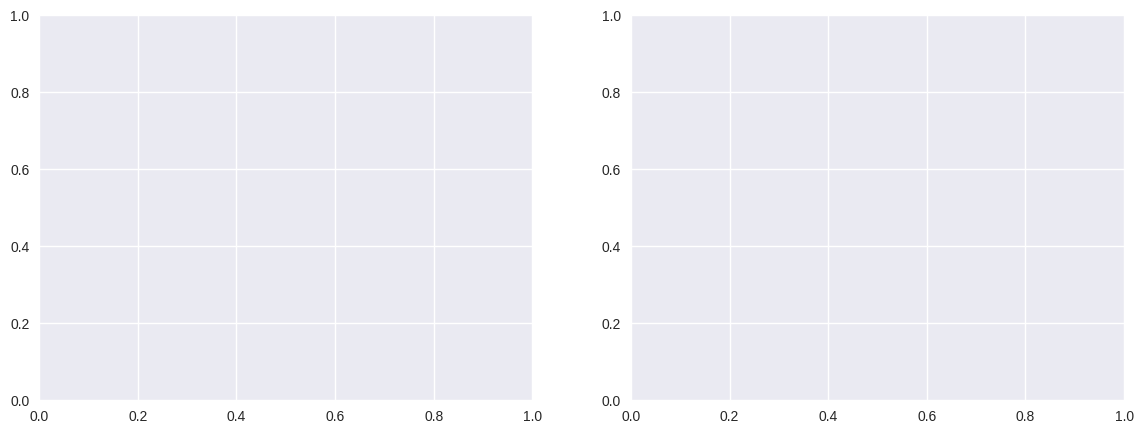

In [ ]:
plot_train_val(history, NUM_EPOCHS, BATCH_SIZE, title="Training and Validation")